# 20221221 Continue to Optimize chamber masking

 It looks like I need to refine chamber centers from initial provide coordinates. I think i can do this by creating a quick small circle mask and then finding a circle within it and assigning that center to be thee true corner

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import skimage
import glob
import os
import imutils
from typing import Tuple, List
from sklearn.linear_model import LinearRegression
import math
from copy import deepcopy
import pandas as pd
from pathlib import Path
from collections import namedtuple

### Starting with making a FeatureFinder class to clean things up
___

In [2]:
STEVE_ROTATION = -1.15

Corners(tl=(4, 0), tr=(0, 0), bl=(4, 4), br=(0, 4))
251 305


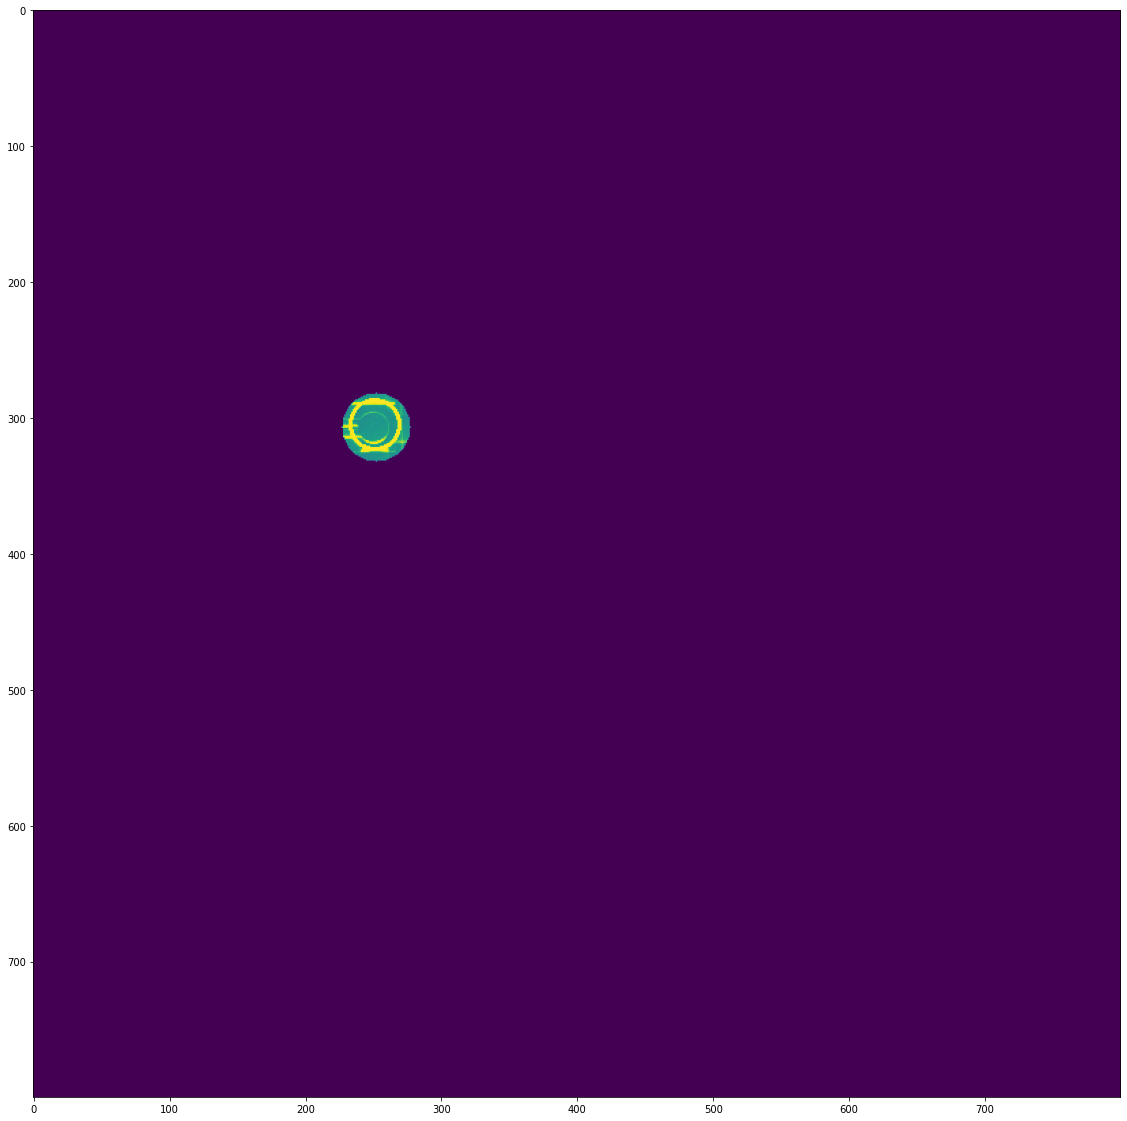

In [51]:
class FeatureFindingException(Exception):
    pass

class FeatureFinder:
    Corner = namedtuple('Corners', ['tl', 'tr', 'bl', 'br'])

    def __init__(self, brightfield_image_folder: str, camera_rotation_correction: float, overlap_percentage: int, brightfield_image_channel: str = "egfp") -> None:
        # if brightfield_image_folder[-1] == "/":
        #     brightfield_image_folder = brightfield_image_folder[:-1]
        # if Path(brightfield_image_folder).joinpath(brightfield_image_channel).exists():

        #     self.image_dir = Path(brightfield_image_folder).joinpath(brightfield_image_channel,
        #      os.path.basename(brightfield_image_folder) + "_" + brightfield_image_channel)       
        #     print(self.image_dir)     
        # else:
            # raise FeatureFindingException("Please provide a valid image folder")
        self.image_dir = Path(brightfield_image_folder)
        self.raster_image_dict = {}
        self.camera_rotation_correction = camera_rotation_correction
        self.overlap = overlap_percentage
        self.raster_idx_corners = None

        
        self._validate_images()
        



    def _validate_images(self):
        img_path_list = list(self.image_dir.glob("*"))
        for img_path in img_path_list:
            self.raster_image_dict[self._parse_raster_grid_dims(img_path)] = img_path

        max_raster_dim = np.max(list(self.raster_image_dict.keys()), axis=0)
        min_raster_dim = np.min(list(self.raster_image_dict.keys()), axis=0)
        num_rasters = np.product(max_raster_dim + 1)

        # SET RASTER INDEXES HERE, PROBABLY NEED TO CHANGE AT SOME POINT
        self.raster_idx_corners = FeatureFinder.Corner(
            (max_raster_dim[0], min_raster_dim[1]),  # tl
            (min_raster_dim[0], min_raster_dim[1]),  # tr
            (max_raster_dim[0], max_raster_dim[1]),  # bl
            (min_raster_dim[0], max_raster_dim[1])   # br
        )

        print(self.raster_idx_corners)
        if num_rasters != len (img_path_list):
            raise FeatureFindingException("Number of images does not match expected raster dimension.")

        example_img = cv2.imread(str(img_path_list[0]), cv2.IMREAD_GRAYSCALE)
        
        image_dim = example_img.shape[0]
        self.image_dim = image_dim 
        self.image_dim_without_overlap = self.image_dim - self.image_dim / 10
        pass
    
    @staticmethod
    def _parse_raster_grid_dims(img_path: Path):
        string_raster_coords = img_path.name.split("Pos")[-1].split("_")[:2] 
        return int(string_raster_coords[0]), int(string_raster_coords[1])

    def _get_chamber_centers_from_user():
        raise NotImplementedError("Still working on this")

    def assign_corner_chambers(self, top_left: Tuple[int,int], top_right: Tuple[int,int], bottom_left: Tuple[int,int], bottom_right: Tuple[int,int], chamber_find_kwargs: dict):
        fig = plt.figure(figsize=(20,20))
        top_left_img = cv2.imread(str(self.raster_image_dict[self.raster_idx_corners.tl]), cv2.IMREAD_GRAYSCALE)

        # create mask
        mask = np.zeros(top_left_img.shape, dtype=np.uint8)

        mask = cv2.circle(mask, (top_left[0],top_left[1]), 25, (255, 255, 255), -1)

        top_left_masked = cv2.bitwise_and(top_left_img, mask)
        # Draw detected circles

        circles = self.find_chambers(top_left_masked, **chamber_find_kwargs)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles:
                # outer circle
                ## cv2.circle(image, center_coordinates, radius, color, thickness)
                cv2.circle(top_left_masked, (i[0], i[1]), i[2], (255, 0, 0), 2)
                print(i[0], i[1])
        plt.imshow(top_left_masked)
    
        #self.corner_chambers = FeatureFinder.Corner()

    def _rotate_image_coords(self, coords: tuple) :
        img_mid = self.image_dim / 2
        x, y = coords
        angle = angle * math.pi / 180
        xr = (x - img_mid) * math.cos(angle) - (y - img_mid) * math.sin(angle) + img_mid
        yr = (x - img_mid) * math.sin(angle) + (y - img_mid) * math.cos(angle) + img_mid

        return int(xr), int(yr)

    def _calc_whole_slide_coords(self, raster_coords: tuple, raster_idx: tuple):
        return np.add(raster_coords, np.multiply((self.image_dim_without_overlap, self.image_dim_without_overlap), raster_idx))

    def _assign_raster_idx_from_whole_slide_coord(self, ws_coord: np.array):
        raster_idx = np.floor_divide(ws_coord, (self.image_dim_without_overlap, self.image_dim_without_overlap))
        return int(raster_idx[0]), int(raster_idx[1])

    def _calc_raster_image_coords(self,ws_coord: np.array, raster_idx: tuple):
        return np.uint16(np.subtract(ws_coord, np.multiply((self.image_dim_without_overlap, self.image_dim_without_overlap), raster_idx)))

    @staticmethod
    def find_chambers(img, chamber_rad: int, outer_chamber_bound: int, circle_param_1: int, circle_param_2: int):
        if type(img) == str:
            img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore") # Will throw warning due to precision loss
        #     cimg = skimage.img_as_ubyte(img, force_copy = True)
            
        # searchRadii
        min_rad = chamber_rad
        max_rad = min_rad + outer_chamber_bound

        # find circles
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=circle_param_1,param2=circle_param_2, minRadius=min_rad, maxRadius=max_rad)

        grad_threshold = circle_param_1
        # If no circles found, loosen gradient threshold
        while type(circles) is not np.ndarray and grad_threshold > 5:
            circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=grad_threshold, param2=circle_param_2, minRadius=min_rad+1, maxRadius=max_rad+2)
            grad_threshold -= 1

        # If still none found, return a blank chamber (failed)
        if not np.any(circles): 
            m = 'No chamber border found'
            warnings.warn(m)

        return circles[0]  

feature_finder = FeatureFinder("../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/", STEVE_ROTATION, 10)

chamber_find_args = {
    "chamber_rad": 15,
    "outer_chamber_bound": 4,
    "circle_param_1": 50,
    "circle_param_2": 40
}
feature_finder.assign_corner_chambers(top_left = (252, 307), top_right = (504, 313), bottom_left = (245,606), bottom_right = (498, 609), chamber_find_kwargs = chamber_find_args)

In [43]:
top_right = (504, 313)
bottom_right = (498, 609)
top_left = (252, 307)
bottom_left = (245,606)

20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp


### Chamber location function
___

In [127]:
def find_chambers(img, chamber_rad: int, outer_chamber_bound: int, circle_param_1: int, circle_param_2: int):
    if type(img) == str:
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore") # Will throw warning due to precision loss
    #     cimg = skimage.img_as_ubyte(img, force_copy = True)
        
    # searchRadii
    min_rad = chamber_rad
    max_rad = min_rad + outer_chamber_bound

    # find circles
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=circle_param_1,param2=circle_param_2, minRadius=min_rad, maxRadius=max_rad)

    grad_threshold = circle_param_1
    # If no circles found, loosen gradient threshold
    while type(circles) is not np.ndarray and grad_threshold > 5:
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,2,10,param1=grad_threshold, param2=circle_param_2, minRadius=min_rad+1, maxRadius=max_rad+2)
        grad_threshold -= 1

    # If still none found, return a blank chamber (failed)
    if not np.any(circles): 
        m = 'No chamber border found'
        warnings.warn(m)

    return circles[0]    

In [4]:
def get_rotation_adjustment(chamber_array: np.array, aligned_threshold: int = 75):
    # get left most 3 wells (min x-axis)
    min_x_chambers = chamber_array[chamber_array[:,0].argsort()[:3]]
    # remove radii
    min_x_chamber_coords = min_x_chambers[:,:2]
    # fit first pass model
    model = LinearRegression().fit(min_x_chamber_coords[:,0].reshape(-1,1), min_x_chamber_coords[:,1])

    pred_errors = model.predict(chamber_array[:,0].reshape(-1,1)) - chamber_array[:,1]

    updated_min_x_chambers = chamber_array[np.argwhere(pred_errors < aligned_threshold)].reshape(-1,3)

    updated_model = LinearRegression().fit(updated_min_x_chambers[:,0].reshape(-1,1), updated_min_x_chambers[:,1])

    rotation_angle = math.atan(updated_model.coef_)

    return rotation_angle


# Find Chambers from Brighftield

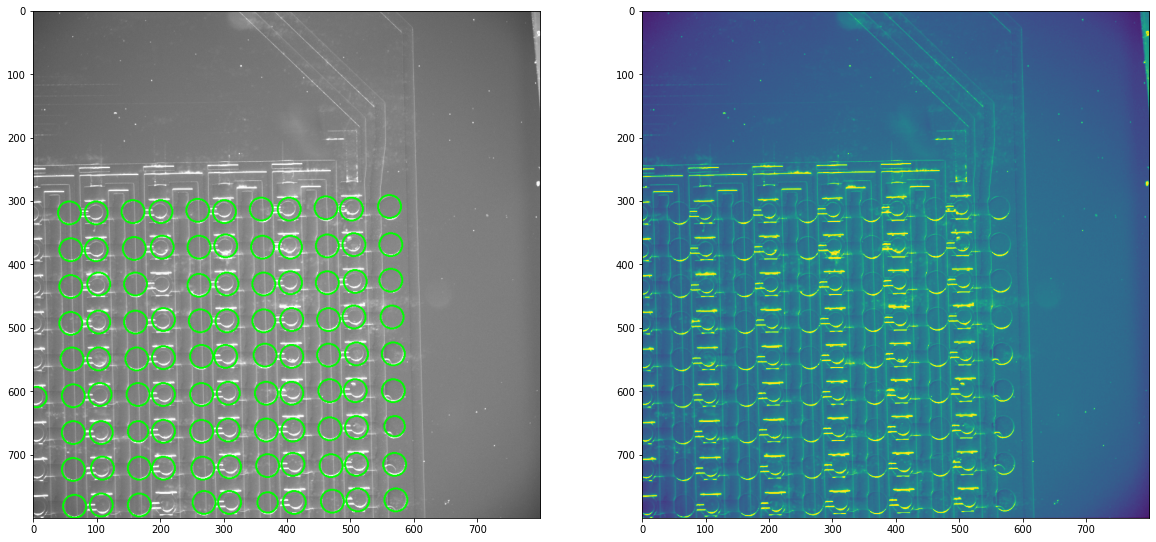

In [5]:
chamber_rad = 15
outer_chamber_bound = 4
circle_param_1 = 50
circle_param_2 = 40
grid_coords_raw = []


f, axarr = plt.subplots(1,2, figsize=(20,10))
rotation_angle = None

img_path = "../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# find circles in image
circles = find_chambers(img_path=img_path, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)

# find rotation adjustment
if rotation_angle is None:
    rotation_angle = get_rotation_adjustment(circles)

# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
full_color_img = cv2.imread(img_path)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles:
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
output_image = imutils.rotate(img, angle=-rotation_angle)

axarr[1].imshow(output_image)  
axarr[0].imshow(full_color_img)

# looking at whole slide image

In [96]:
img_list = sorted(glob.glob("../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/*/*"))
imgs =[imutils.rotate(cv2.imread(img), angle=-1.15) for img in img_list]


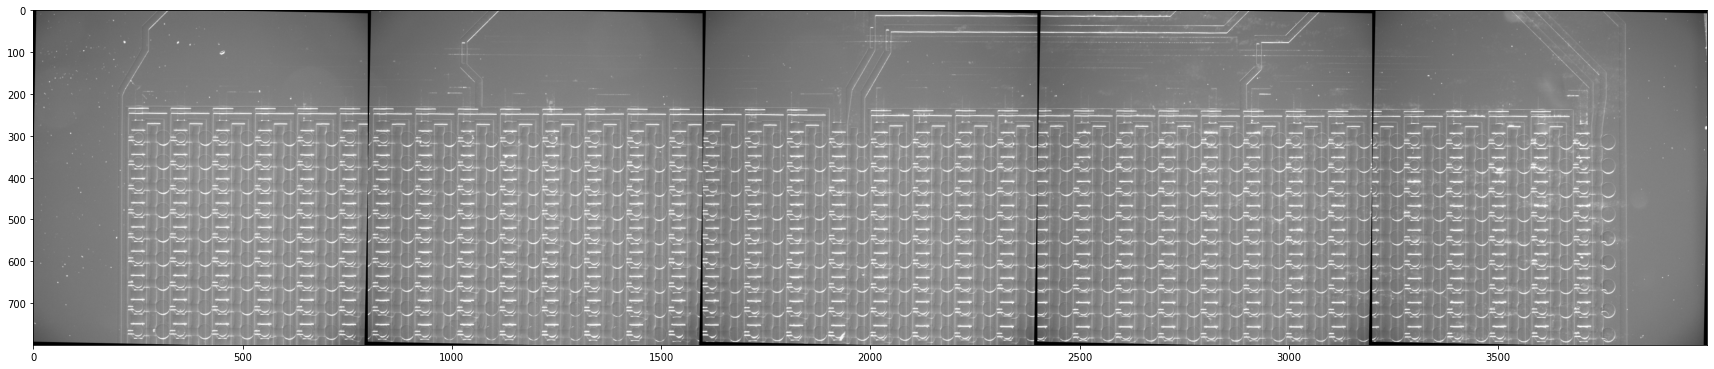

In [97]:
def concat_vh(list_2d):
    
      # return final image
    return cv2.vconcat([cv2.hconcat(list_h) 
                        for list_h in list_2d])

# function calling
img_tile = concat_vh([[imgs[20], imgs[15], imgs[10], imgs[5], imgs[0]]])
# show the output image
fig = plt.figure(figsize=(30,30))
plt.imshow(img_tile)

# Use corner chamber coordinates to interpolate a chamber mask

In [107]:
top_right = (504, 313)
bottom_right = (498, 609)
top_left = (252, 307)
bottom_left = (245,606)

top_right_rotated = rotate_image_coords(top_right, STEVE_ROTATION)
bottom_right_rotated = rotate_image_coords(bottom_right, STEVE_ROTATION)
top_left_rotated = rotate_image_coords(top_left, STEVE_ROTATION)
bottom_left_rotated = rotate_image_coords(bottom_left, STEVE_ROTATION)

## Quadrilateral Interpolation Function from D. Mohktari Code

In [25]:
def quadrilateralInterp(corners, dims):
    """
    Grid the chip using the corners as vertices and the dims as the number of latice points
    in the x and y directions.

    Arguments:
        (tuple | namedtuple) corners: cornerpositions of the form 
            ((ULx, ULy),(URx, URy),(LLx, LLy),(LRx, LRy))
        (tuple) dims: chip dimensions (num columns, num rows)

    Returns:
        (np.ndarray) a 2-D array of latice (x, y) coordinates
    """

    def interp(p1, p2, divs):
        y = np.linspace(p1[0], p2[0], divs, dtype = int)
        x = np.linspace(p1[1], p2[1], divs, dtype = int)
        return np.stack((x, y), axis = 1)


    left = interp(corners.ul, corners.bl, dims[1])
    right = interp(corners.ur, corners.br, dims[1])
    mesh = [interp(p1, p2, dims[0]) for p1, p2 in zip(left, right)]
    return np.stack(mesh, axis = 1)

In [108]:
ChipCorner = namedtuple('Corners', ['ul', 'ur', 'bl', 'br'])

corners = ChipCorner(*(calc_whole_slide_coords(top_left_rotated, (0,0)), 
                    calc_whole_slide_coords(top_right_rotated, (4,0)), 
                    calc_whole_slide_coords(bottom_left_rotated, (0,4)), 
                    calc_whole_slide_coords(bottom_right_rotated, (4,4))))

In [113]:
chamber_centers = quadrilateralInterp(corners, (32,56))

In [114]:
assigned_raster_coords = np.apply_along_axis(assign_raster_idx_from_whole_slide_coord, 2, chamber_centers)

In [115]:
top_right_mask = (assigned_raster_coords == [4, 0]).all(axis=2)

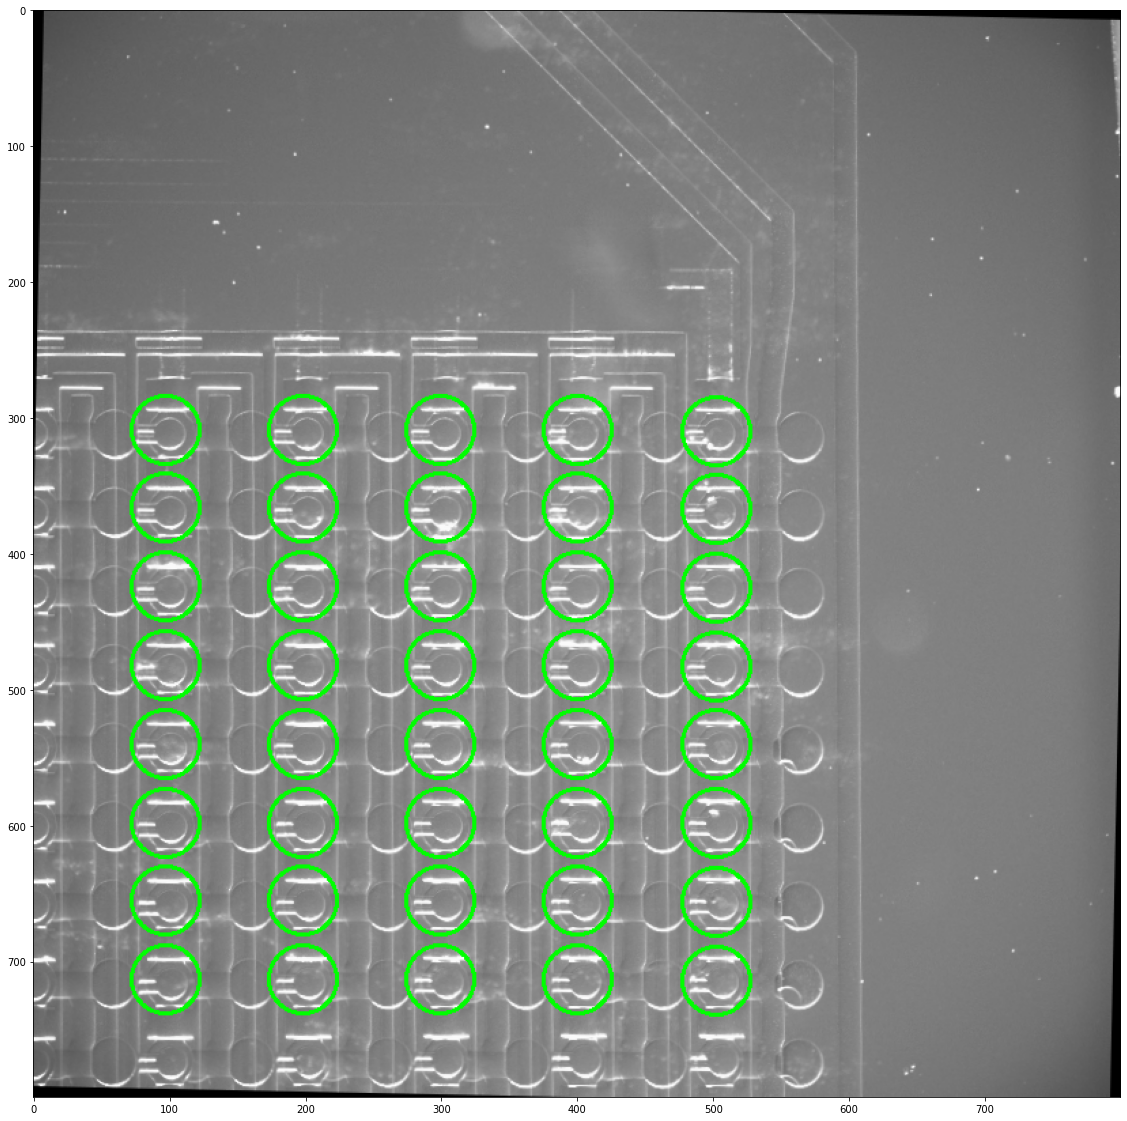

In [123]:
fig = plt.figure(figsize=(20,20))

img_path = "../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
full_color_img = imutils.rotate(cv2.imread(img_path), STEVE_ROTATION)

# Draw detected circles

for i in np.apply_along_axis(calc_raster_image_coords,1,chamber_centers[top_right_mask], (4,0)):
   
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), 25, (0, 255, 0), 2)

plt.imshow(full_color_img)

Next i'll need to read about masking, it looks like i may want to correct the initial center points byt creating an initial mask, then chamber finding and using new center

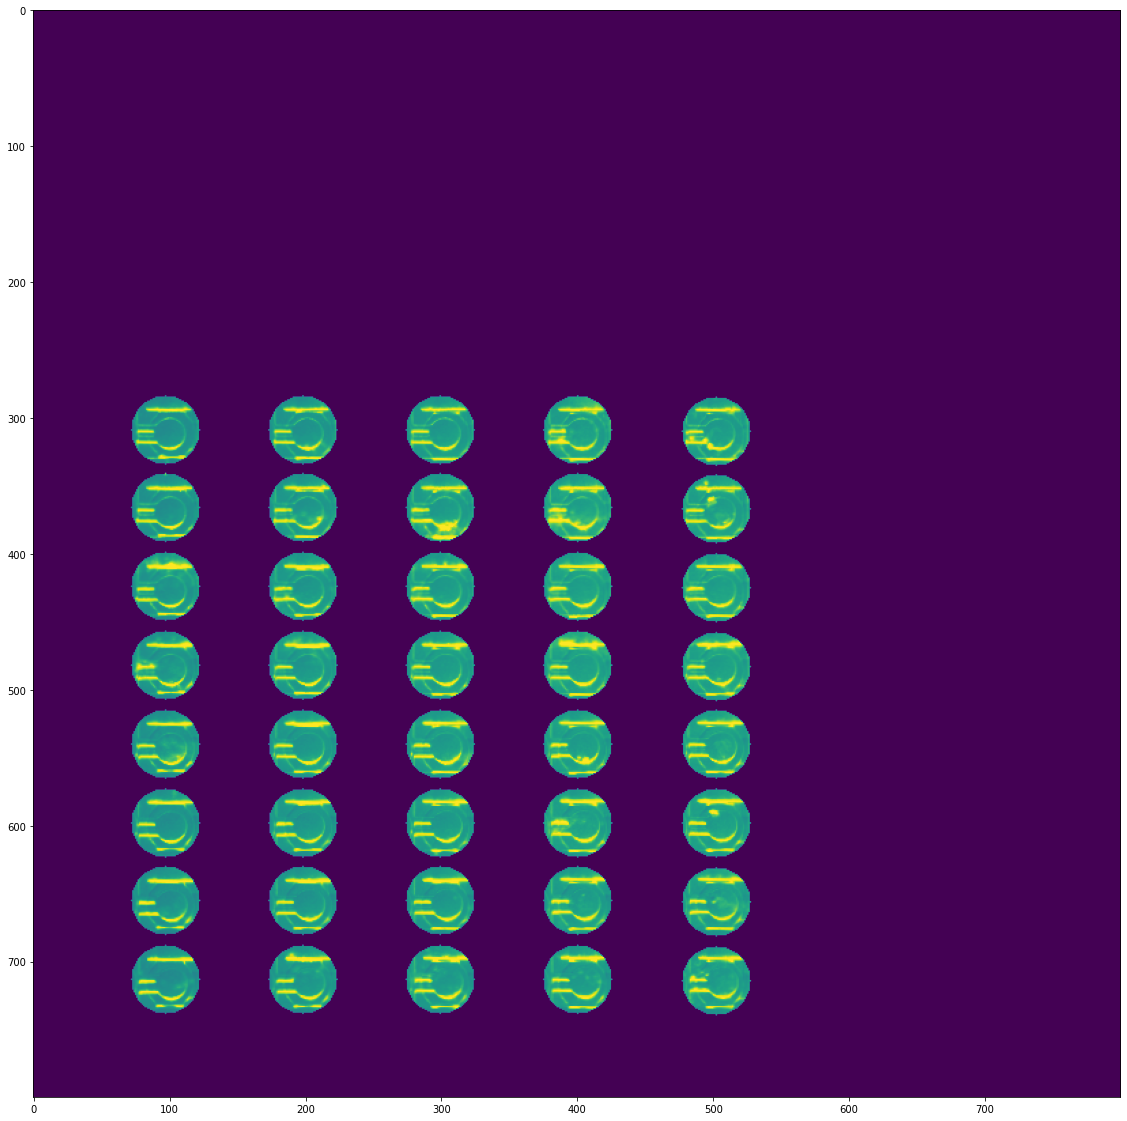

In [129]:
fig = plt.figure(figsize=(20,20))

img_path = "../../data/20221130-084247-d1_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x/egfp/20221130-084247_real-egfp-50-brightfield_egfp_50_Sola_4x4_Kinetix-DynamicRange_4x_egfp/3-Pos000_000_50.tif"
    
# get image dimensions
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = imutils.rotate(img, STEVE_ROTATION)

# create mask
mask = np.zeros(img.shape, dtype=np.uint8)

for i in np.apply_along_axis(calc_raster_image_coords,1,chamber_centers[top_right_mask], (4,0)):
        
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        mask = cv2.circle(mask, (i[0], i[1]), 25, (255, 255, 255), -1)

masked = cv2.bitwise_and(img, mask)

plt.imshow(masked)

# Find Chambers from Brighftield with Masking

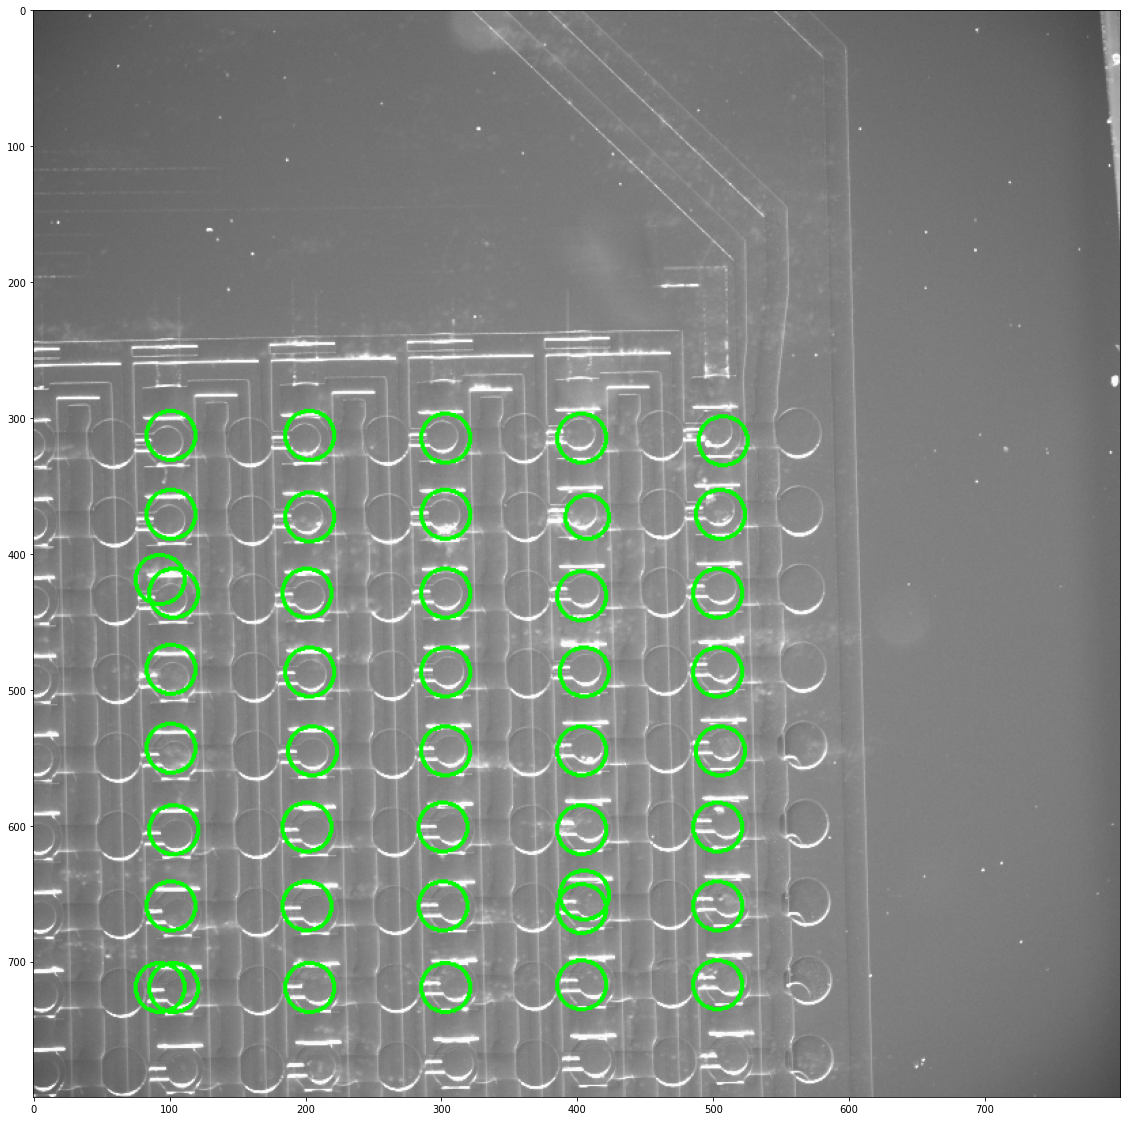

In [130]:
chamber_rad = 15
outer_chamber_bound = 4
circle_param_1 = 50
circle_param_2 = 40


fig = plt.figure(figsize=(20,20))

    
# find circles in image
circles = find_chambers(img=masked, chamber_rad=chamber_rad, outer_chamber_bound=outer_chamber_bound, circle_param_1=circle_param_1, circle_param_2=circle_param_2)


full_color_img = cv2.imread(img_path)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles:
        # outer circle
        ## cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(full_color_img, (i[0], i[1]), i[2], (0, 255, 0), 2)

plt.imshow(full_color_img)